In [1]:
import pandas as pd
import numpy as np
import cellstates as cs
import matplotlib.pyplot as plt
import matplotlib

This notebook shows an example analysis of a dataset with cellstates. We are looking at 1937 pancreatic cells from one human donor. 

### Reference
Baron, M. et al. A Single-Cell Transcriptomic Map of the Human and Mouse Pancreas Reveals Inter- and Intra-cell Population Structure. Cell Syst. 3, 346-360.e4 (2016).

In [2]:
filepath = '../test_data/baron/Gene_table.txt.gz'
df = pd.read_csv(filepath, sep='\t', index_col=0)
df.head()

,human1_lib1.final_cell_0001,human1_lib1.final_cell_0002,human1_lib1.final_cell_0003,human1_lib1.final_cell_0004,human1_lib1.final_cell_0005,human1_lib1.final_cell_0006,human1_lib1.final_cell_0007,human1_lib1.final_cell_0008,human1_lib1.final_cell_0009,human1_lib1.final_cell_0010,...,human1_lib3.final_cell_0731,human1_lib3.final_cell_0732,human1_lib3.final_cell_0733,human1_lib3.final_cell_0734,human1_lib3.final_cell_0735,human1_lib3.final_cell_0736,human1_lib3.final_cell_0737,human1_lib3.final_cell_0738,human1_lib3.final_cell_0739,human1_lib3.final_cell_0740
GeneID,,,,,,,,,,,,,,,,,,,,,
A1BG,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
A1CF,4,0,0,0,0,1,0,1,0,0,...,0,0,0,1,0,0,1,0,0,0
A2M,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
A4GALT,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
AAAS,0,0,0,1,0,0,0,1,0,0,...,0,0,0,1,0,0,0,0,0,0


In [3]:
clusters = np.loadtxt('../test_data/baron/optimized_clusters.txt', dtype=np.int)
lmbd = np.loadtxt('../test_data/baron/dirichlet_pseudocounts.txt')
hierarchy_df = pd.read_csv('../test_data/baron/cluster_hierarchy.tsv', sep='\t')
score_df = pd.read_csv('../test_data/baron/hierarchy_gene_scores.tsv', sep='\t')
display(score_df.head())
display(hierarchy_df.head())

,cluster_new,cluster_old,delta_LL,A1BG,A1CF,A2M,A4GALT,AAAS,AACS,AADAC,...,ZWILCH,ZWINT,ZXDA,ZXDB,ZXDC,ZYG11B,ZYX,ZZEF1,ZZZ3,pk
0,26,37,-4.140421,0.002046,0.033631,0.011783,0.007773,0.034776,-0.559480,0.011374,...,0.006628,0.000736,0.001227,0.010065,0.011701,0.033058,0.058753,0.032649,0.034204,-0.194608
1,7,13,-21.066154,-0.006145,-0.018990,0.067171,0.044314,-0.045106,0.049381,0.064839,...,0.005139,-0.004705,-0.007842,-0.019785,-0.001553,-0.115066,-0.715735,-0.125494,-0.069146,0.147324
2,19,44,-22.394298,0.000396,0.006509,0.002280,0.001504,0.006731,0.006224,0.002201,...,0.001283,0.000143,0.000238,0.001948,0.002265,0.006398,0.011371,0.006319,0.006620,0.005606
3,22,50,-23.007094,0.000693,0.011387,0.003989,0.002632,0.011775,0.010888,0.003851,...,0.002244,0.000249,0.000416,0.003408,0.003962,0.011193,-0.241747,0.011054,-0.114862,0.009808
4,34,40,-26.100780,0.003243,-0.257394,-0.292024,0.012323,-0.154951,0.050979,0.018031,...,0.010507,0.001167,0.001946,-0.194123,0.018549,0.052406,0.093140,0.051758,0.054222,0.045920


,cluster_new,cluster_old,delta_LL
0,26,37,-4.140421
1,7,13,-21.066154
2,19,44,-22.394298
3,22,50,-23.007094
4,34,40,-26.100780


In [4]:
data = df.values.astype(np.int)
data.shape

(16016, 1937)

In [5]:
clst = cs.Cluster(data, lmbd, clusters, max_clusters=max(clusters)+1)

# Visualization with PCA

## Plotting cellstates on PCA

In [6]:
# calculate PCA
from sklearn.decomposition import PCA

n_scale = np.median(data.sum(axis=0))

tpm_data = n_scale*data/data.sum(axis=0)
X = np.log(tpm_data + 1).T
pca = PCA(n_components=16)
pca.fit(X)
X_pca = pca.transform(X)

pca_var = pca.explained_variance_ratio_

Plotting all cells and clusters on PCA quickly looks very messy

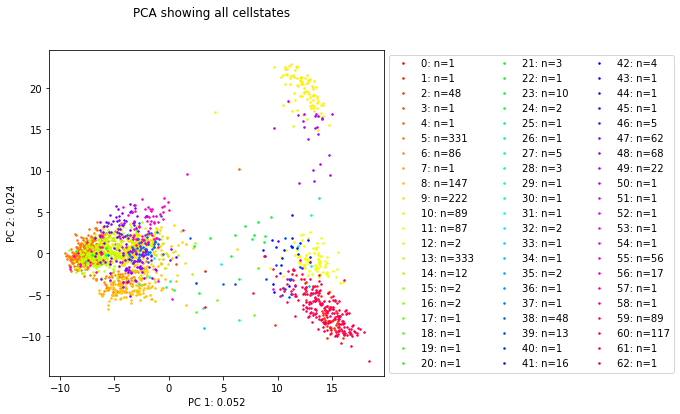

In [7]:
# define colors
cluster_names, cluster_sizes = np.unique(clusters, return_counts=True)
colors = plt.cm.hsv(np.linspace(0, 1, clst.n_clusters))

fig, ax = plt.subplots(1, 1, figsize=(6,6))

# plot first 2 PCA components
c1, c2 = 0, 1
x = X_pca[:, c1]
y = X_pca[:, c2]
for c, color in zip(cluster_names, colors):
    cond = (clusters==c)
    label = f'{c}: n={np.sum(cond)}'
    ax.plot(x[cond], y[cond], '.', ms=3, label=label, color=color)
ax.set_xlabel(f'PC {c1+1}: {pca_var[c1]:.3f}')
ax.set_ylabel(f'PC {c2+1}: {pca_var[c2]:.3f}')
l = plt.legend(ncol=3)
l.set_bbox_to_anchor([1., 1])

fig.suptitle('PCA showing all cellstates')
    
plt.show()

One way we can make this plot tidier is by finding the  **modal gene expression state** of each cluster and only plotting these. 

*NB*: The inferred modal gene expression state of small clusters might be shifted w.r.t. the positions of the cells themselves.

In [8]:
# find modal gene expression states of all cellstates
all_gene_expression_states = np.vstack([clst.get_expressionstate(c) for c in cluster_names])

log_tpm_states = np.log(all_gene_expression_states*n_scale+1)
X_pca_states = pca.transform(log_tpm_states)

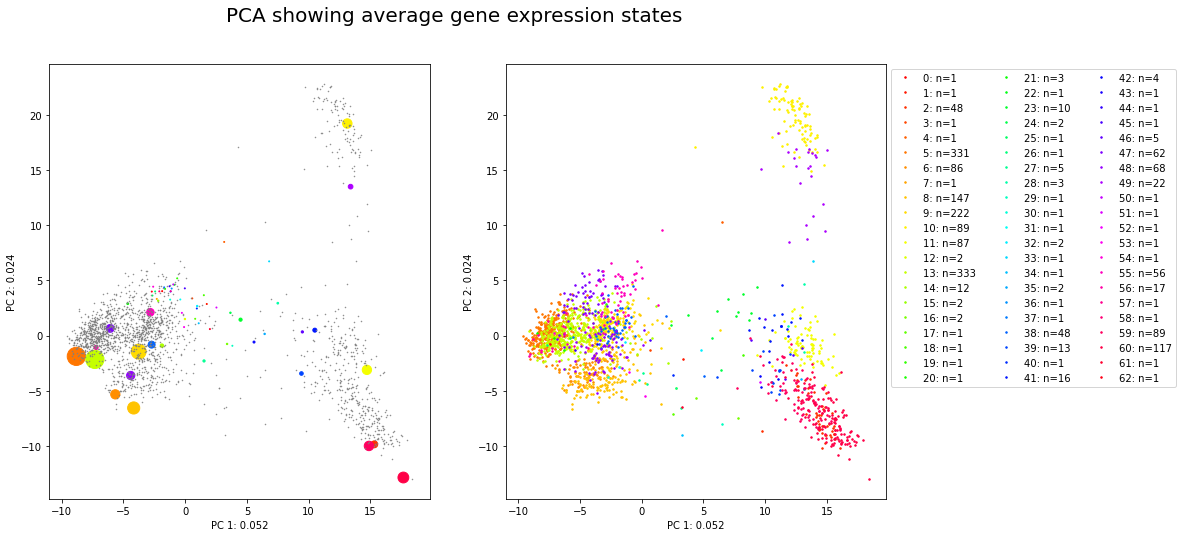

In [9]:
fig, axs = plt.subplots(1, 2, figsize=(15, 8,))

c1, c2 = 0, 1

# plot centres of cellstates with cells in background
ax = axs[0]
ax.plot(X_pca[:, c1], X_pca[:, c2], '.', ms=1, color='gray')
ax.scatter(X_pca_states[:, c1], X_pca_states[:, c2], 
           s=cluster_sizes, 
           c=colors)
ax.set_xlabel(f'PC {c1+1}: {pca_var[c1]:.3f}')
ax.set_ylabel(f'PC {c2+1}: {pca_var[c2]:.3f}')

# plot previous PCA for comparison
ax = axs[1]
x = X_pca[:, c1]
y = X_pca[:, c2]
for c, color in zip(cluster_names, colors):
    cond = (clusters==c)
    label = f'{c}: n={np.sum(cond)}'
    ax.plot(x[cond], y[cond], '.', ms=3, label=label, color=color)
ax.set_xlabel(f'PC {c1+1}: {pca_var[c1]:.3f}')
ax.set_ylabel(f'PC {c2+1}: {pca_var[c2]:.3f}')
l = plt.legend(ncol=3)
l.set_bbox_to_anchor([1., 1])


fig.suptitle(f'PCA showing average gene expression states', size=20)
plt.show()

Another way to better understand the large-scale structure and get a tidier representation is to look at **merged clusters**:

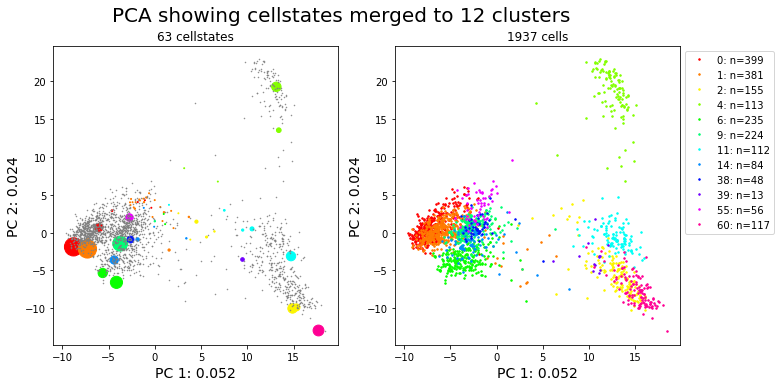

In [10]:

nc = 12 # number of clusters

# array of cluster indices for all cells
merged_clusters = cs.clusters_from_hierarchy(hierarchy_df, cluster_init=clusters, steps= - nc + 1)

# array of cluster indices for all cellstates
merged_clusters_cellstates = cs.clusters_from_hierarchy(hierarchy_df, steps=-nc+1)


cluster_names, cluster_sizes = np.unique(merged_clusters, return_counts=True)
colors = plt.cm.hsv(np.linspace(0, 1, nc+1))

fig, axs = plt.subplots(1, 2, figsize=(10, 5.5))

# plot first 2 PCA components
c1, c2 = 0, 1

# plot centres of cellstates
ax = axs[0]
ax.plot(X_pca[:, c1], X_pca[:, c2], '.', ms=1, color='gray')
for i, c in enumerate(cluster_names):
    cond = (merged_clusters_cellstates==c)
    ax.scatter(X_pca_states[cond, c1], X_pca_states[cond, c2], 
               s=clst.cluster_sizes[cond], 
               color=colors[i])
ax.set_xlabel(f'PC {c1+1}: {pca_var[c1]:.3f}', size=14)
ax.set_ylabel(f'PC {c2+1}: {pca_var[c2]:.3f}', size=14)

ax.set_title(f'{clst.n_clusters} cellstates')


# plot previous PCA for comparison
ax = axs[1]
x = X_pca[:, c1]
y = X_pca[:, c2]
for c, color in zip(cluster_names, colors):
    cond = (merged_clusters==c)
    label = f'{c}: n={np.sum(cond)}'
    ax.plot(x[cond], y[cond], '.', ms=3, label=label, color=color)
ax.set_xlabel(f'PC {c1+1}: {pca_var[c1]:.3f}', size=14)
ax.set_ylabel(f'PC {c2+1}: {pca_var[c2]:.3f}', size=14)

ax.set_title(f'{clst.N_samples} cells')
l = plt.legend(ncol=1)
l.set_bbox_to_anchor([1., 1])

plt.subplots_adjust(left=0.1, right=0.97)

fig.suptitle(f'PCA showing cellstates merged to {nc} clusters', size=20)
plt.show()

# Analysis of cluster hierarchy

## Plotting basic structure with scipy dendrograms

The default scipy visualization includes all cellstates as leaves and gives a general overview of the data structure. 

*NB*: single leaves cannot be colored in scipy and are shown in gray, not the color assigned above

/scicore/home/nimwegen/grobecke/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: The 'linthreshy' parameter of __init__() has been renamed 'linthresh' since Matplotlib 3.3; support for the old name will be dropped two minor releases later.
  """


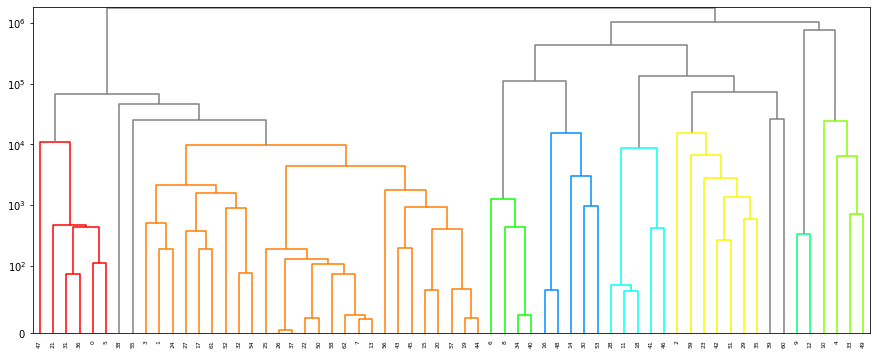

In [11]:
fig, ax = plt.subplots(1,1, figsize=(15, 6))
R = cs.plot_hierarchy_scipy(hierarchy_df, n_groups=nc, colors=colors)

# setting the yscale to symlog allows us to better see the fine structure of the tree
ax.set_yscale('symlog', linthreshy=1e2)

In [12]:
# if you like working with the scipy hierarchy module, you can use
Z, labels = cs.get_scipy_hierarchy(hierarchy_df, return_labels=True)

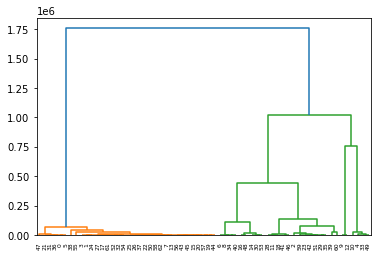

In [13]:
from scipy.cluster.hierarchy import dendrogram
R = dendrogram(Z, labels=labels)

## Plotting basic structure with ete3

The default ete3 visualization includes all cells as leaves (i.e. horizontal width of clusters correspond to their sizes) and gives a general overview of the data structure. 

*NB*: The leaf order may be changed compared to the scipy plot

In [14]:
# I need to properly set the DISPLAY environment to run ete3 on a remote server
# You should probably not run this
import os
os.environ['DISPLAY'] = 'localhost:13.0'  # match to 
!echo $DISPLAY

localhost:13.0


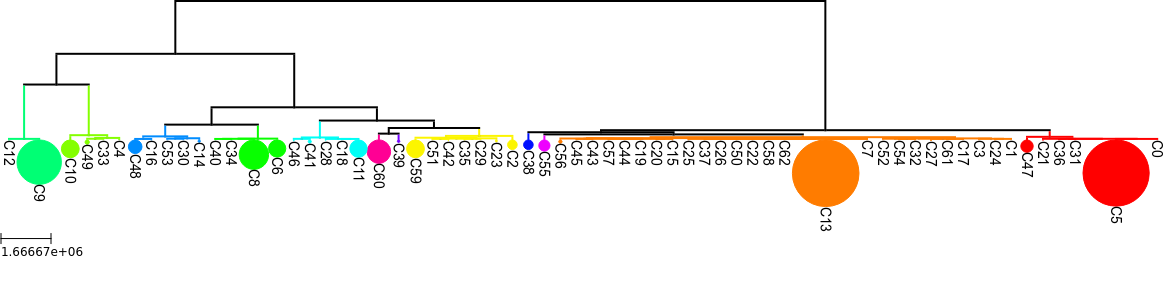

In [15]:
# this built-in function automatically generates a tree visualization with ete3
# example plot with 2 higher-order groups and cellstates as leaves (size proportional to number of cells)
t, ts = cs.plot_hierarchy_ete3(hierarchy_df, clst.clusters, n_groups=nc, 
                               colors=colors, show_cells=False)
ts.show_leaf_name = True  # add leaf labels
t.render('%%inline', tree_style=ts)  # change '%%inline' to e.g. 'plot.pdf' to render to a file

In [16]:
# for a graphical interface of the tree structure, you can also run
t.show(tree_style=ts)

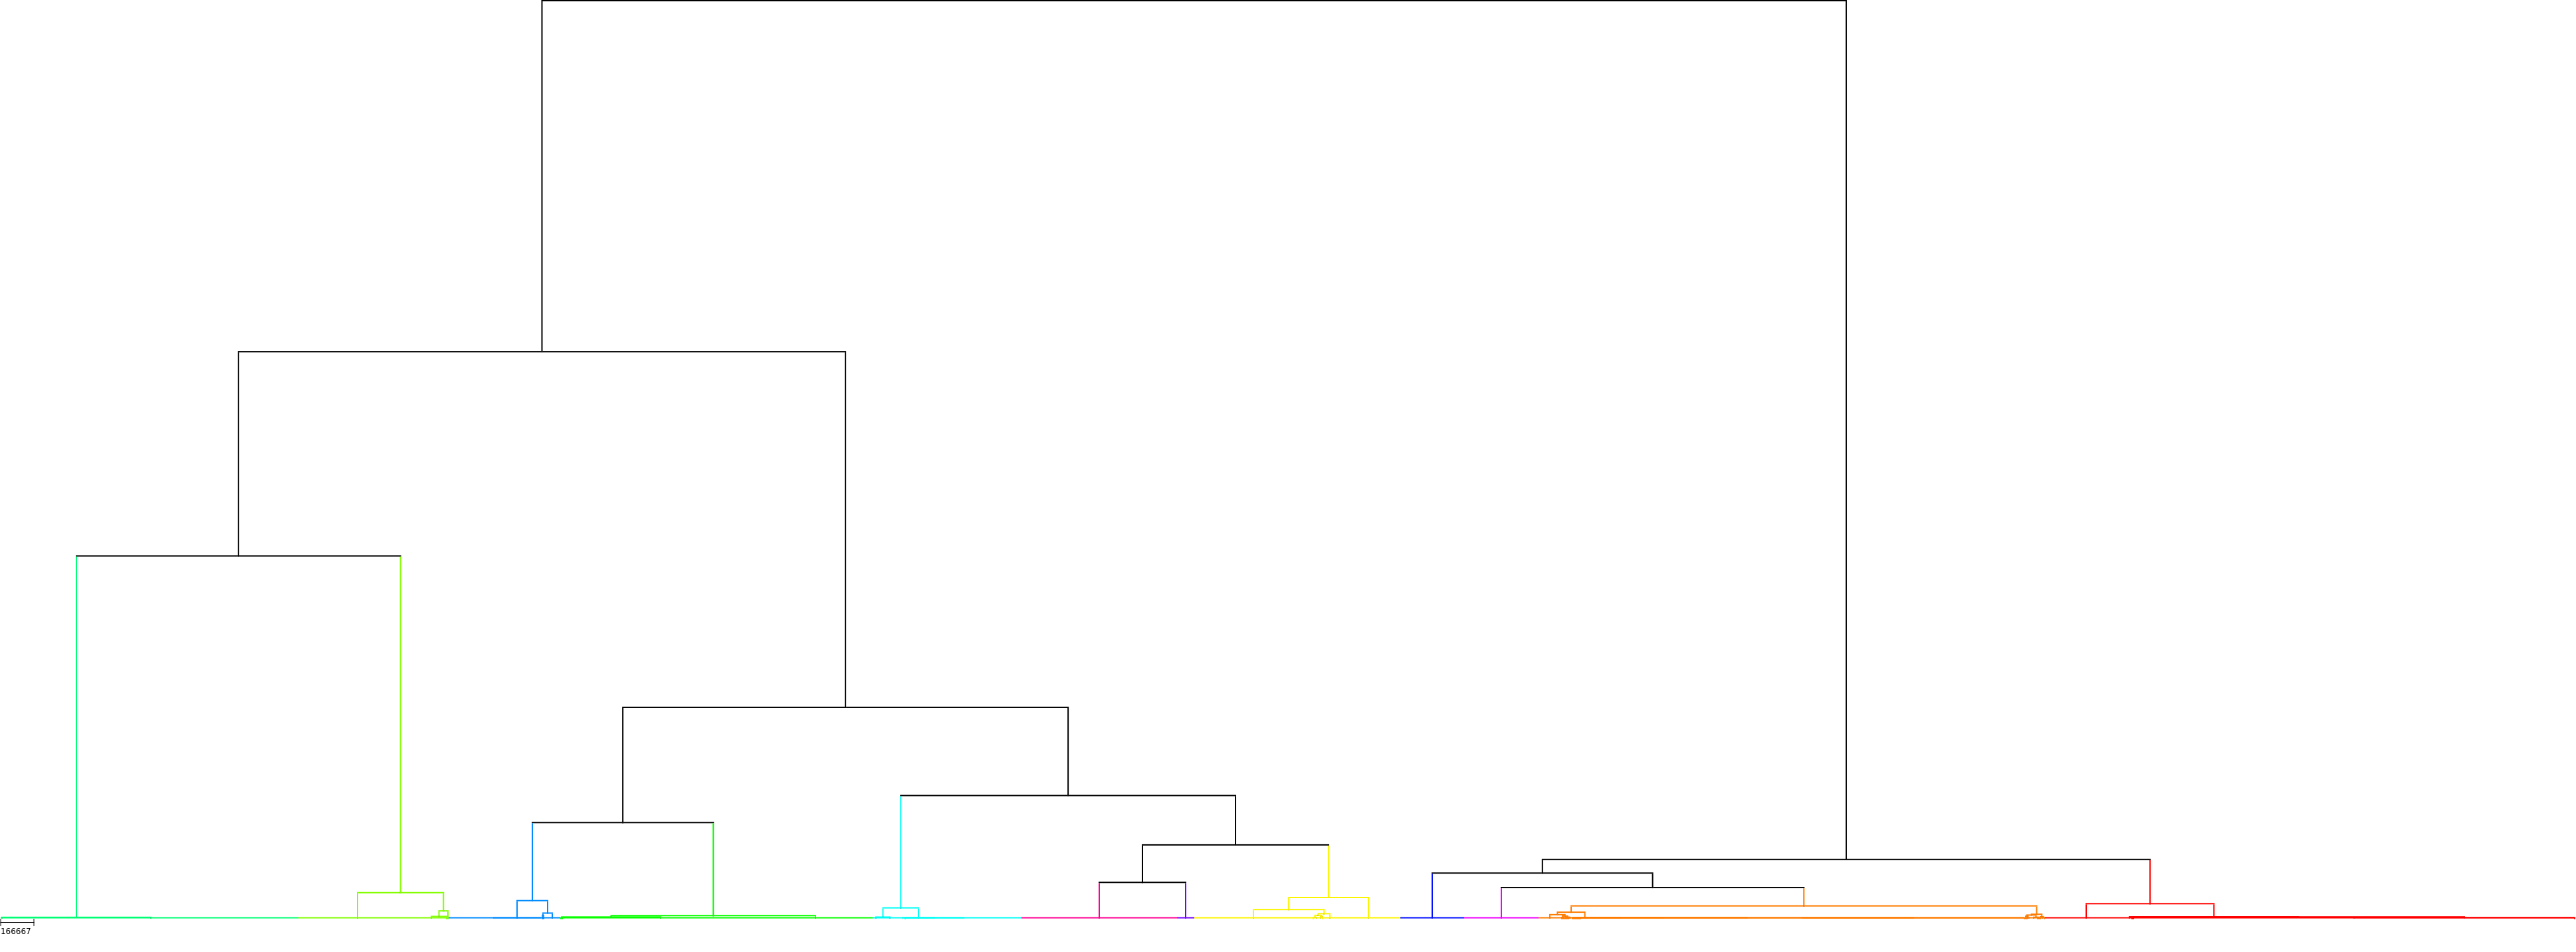

In [17]:
# example plot with 5 higher-order groups and cells as leaves (horizontal distance proportional to number of cells)
t, ts = cs.plot_hierarchy_ete3(hierarchy_df, clst.clusters, n_groups=nc, 
                               colors=colors, show_cells=True)
ts.scale=3e-4  # change vertical scale of figure
t.render('%%inline', tree_style=ts)

In [18]:
# If you like a different tree plotting program that uses newick format inputs, you can use
# check the docstring for further options
newick_string = cs.hierarchy_to_newick(hierarchy_df, clst.clusters, cell_leaves=False)

from ete3 import Tree
# generate ete3 Tree
t = Tree(newick_string, format=1)

# Plotting qualitative attributes in ete3 Tree

Another thing researchers might need to check is the influence of external attributes on clusters ("batch effects"). Below is some code for showing their distribution in each cellstate/cluster in the tree. Here, all data come from a single donor, so I'm going to show how to make such plots by seeing how cells in the different cellstates were annotated in the original paper. 

In [19]:
annotation = np.loadtxt('../test_data/baron/Celltype.txt', dtype=str)
annotation

array(['acinar', 'acinar', 'acinar', ..., 'endothelial', 'beta',
       'quiescent_stellate'], dtype='<U18')

In [20]:
from ete3 import faces, TreeStyle, NodeStyle

def get_TreeStyle_attributes(t, clusters, attributes, colors=None, 
                             show_leaf_name=True,
                             linewidth=2, leaf_scale=0.2):
    """
    show fraction of attributes in each cluster as pie charts
    """
    cluster_names, cluster_sizes = np.unique(clusters, return_counts=True)
    
    attribute_names = np.unique(attributes)
    n_attributes = len(attribute_names)
    
    if colors is None:
        colors = plt.cm.gist_ncar(np.linspace(0, 1, n_attributes+1))[:-1]
    color_map = {at:matplotlib.colors.to_hex(cl) for at, cl in zip(attribute_names, colors)}
    
    ts = TreeStyle()
    ts.show_leaf_name=False
    ts.scale = 3e-5
    ts.rotation = 90
    
    base_color='black'
    base_style = NodeStyle()
    base_style['vt_line_width'] = linewidth
    base_style['hz_line_width'] = linewidth
    base_style['size'] = 0
    base_style["vt_line_color"] = base_color
    base_style["hz_line_color"] = base_color

    t.set_style(base_style)
    for n in t.traverse():
        n.set_style(base_style)
    
    # set up colouring of leaves/cellstates which are called C0, C1, ...
    for cluster_id, cluster_size in zip(cluster_names, cluster_sizes):
        nodes = t.search_nodes(name=f'C{cluster_id}')
        if nodes:
            node = nodes[0]
            
            # make size proportional to size of cluster
            size = cluster_size*leaf_scale
            names, counts = np.unique(attributes[clusters==cluster_id], return_counts=True)
            percents = 100*counts/counts.sum()
            pie_colors = [color_map[a] for a in names]
            pieface = faces.PieChartFace(percents, size, size, colors=pie_colors)
            node.add_face(pieface, column=0)
            
            if show_leaf_name:
                nameface = faces.AttrFace("name", fgcolor="black")
                node.add_face(nameface, column=1)
            
    # add legend
    for at, color in color_map.items():
        ts.legend.add_face(faces.CircleFace(7, color), column=0)
        ts.legend.add_face(faces.TextFace(at), column=1)
    return ts

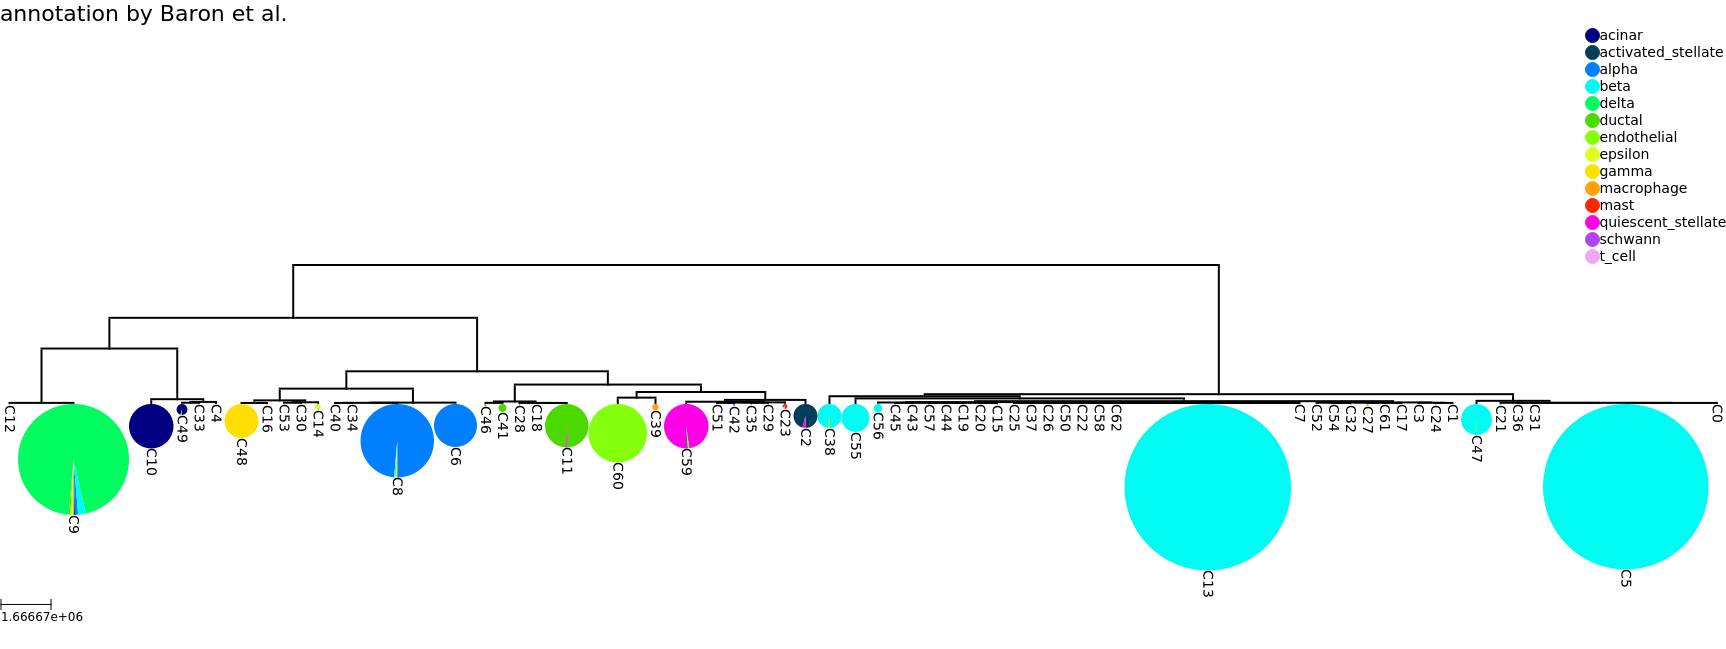

In [21]:
newick_string = cs.hierarchy_to_newick(hierarchy_df, clst.clusters, cell_leaves=False)
t = Tree(newick_string, format=1)
ts = get_TreeStyle_attributes(t, clst.clusters, annotation, colors=None, leaf_scale=0.5)
# ts.show_leaf_name = True
ts.title.add_face(faces.TextFace('annotation by Baron et al.', fsize=16), column=0, )
t.render('%%inline', tree_style=ts)

You can clearly see that cellstates mostly contain cells that have been annotated in the same way!

### Pruning the ete3 Tree

The code below can be used to look at the higher-order structure of the tree (clusters of cellstates are now leaves) and how they were annotated

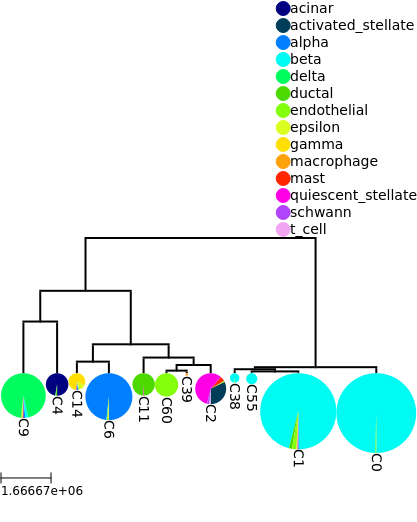

In [22]:
# These two lines are used to construct a pruned tree with nc leaves
newick_string = cs.hierarchy_to_newick(hierarchy_df[-nc+1:], merged_clusters, cell_leaves=False)
t = Tree(newick_string, format=1)

# get TreeStyle to plot external annotation on pruned Tree
ts = get_TreeStyle_attributes(t, merged_clusters, annotation)
display(t.render('%%inline', tree_style=ts))

# Analysing marker gene expression

## Finding marker genes and plotting their expression in PCA space

Each of the merges in the tree is associated with genes that are differentially expressed between the two branches. For example, for the last merge we find the following top genes:

In [23]:
split_id = 0  # first split in tree

gene_scores = score_df.iloc[-split_id - 1, 4:]
gene_scores.sort_values()

INS      -583.505643
IAPP     -361.350913
TIMP1     -98.579812
COL1A1    -76.016180
RBP4      -68.160869
             ...    
CTRB2      12.760575
PPY        13.121456
REG1A      28.895019
GCG        30.726761
SST       133.069067
Name: 61, Length: 16015, dtype: float64

The list shows that *INS* is expressed very differently in both branches while any variation in *SST* expression is very consistent with being noise.

In the original paper, *INS* is marked as a marker gene for Beta cells.

Below, we show *INS* expression of cellstates in the PCA plot

In [24]:
my_gene = 'INS'
gene_id = np.argwhere(df.index.values==my_gene)[0,0]
expression = log_tpm_states[:, gene_id]
norm = plt.Normalize(vmin=expression.min(), vmax=expression.max())
cmap = plt.cm.RdBu_r

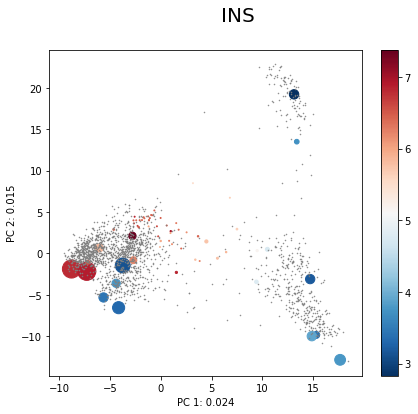

In [25]:
fig, ax = plt.subplots(1, 1, figsize=(7,6))

c1, c2 = 0, 1

# plot centres of cellstates
ax.plot(X_pca[:, c1], X_pca[:, c2], '.', ms=1, color='gray')
sc = ax.scatter(X_pca_states[:, c1], X_pca_states[:, c2], 
                s=clst.cluster_sizes, 
                c=expression,
                cmap='RdBu_r')
ax.set_xlabel(f'PC {c1+1}: {pca_var[2*c1+1]:.3f}')
ax.set_ylabel(f'PC {c2+1}: {pca_var[2*c2+1]:.3f}')
plt.suptitle(my_gene, size=20)
plt.colorbar(sc)
plt.show()

## Plotting gene expression in ete3 Trees

It would be interesting to see how this gene is expressed across the tree. For that purpose, we use the ete3 tree plotting library and create a custom function. 

In [26]:
from ete3 import TreeStyle, NodeStyle

def get_TreeStyle_expression(t, gene_name, log_tpm_states, hierarchy_df, clst,
                             cmap='RdBu_r', linewidth = 2, leaf_scale=0.2):
    
    gene_id = np.flatnonzero(df.index.values==gene_name)[0]
    
    ts = TreeStyle()
    ts.show_leaf_name=True
    ts.scale = 3e-5
    ts.rotation = 90
    
    expression = log_tpm_states[:, gene_id]
    norm = plt.Normalize(vmin=expression.min(), vmax=expression.max())
    cmap = getattr(plt.cm, cmap)
    
    cluster_map = dict(zip(np.flatnonzero(clst.cluster_sizes), range(clst.n_clusters)))
    
    # set up colouring of leaves/cellstates which are called C0, C1, ...
    for leaf in t.iter_leaves():
        cluster_id = cluster_map[int(leaf.name[1:])]
        # find expression of that gene
        E = expression[cluster_id]
        color = matplotlib.colors.to_hex( cmap(norm(E)) )

        style = NodeStyle()
        # make size proportional to size of cluster
        style['size'] = clst.cluster_sizes[cluster_id]*leaf_scale

        # make color 
        style['fgcolor'] = color
        style["vt_line_color"] = color
        style["hz_line_color"] = color
        style['vt_line_width'] = linewidth
        style['hz_line_width'] = linewidth

        leaf.set_style(style)

    unmerged_clusters = clst.clusters.copy()
    
    # Iterate through internal nodes of tree
    n_steps = len(hierarchy_df)
    for i, row in hierarchy_df.iterrows():
        c_new = row.cluster_new
        c_old = row.cluster_old
        # merge clusters
        clst.combine_two_clusters(c_new, c_old)

        # find expression of gene in new merged cluster
        E = np.log(clst.get_expressionstate(c_new)[gene_id]*n_scale + 1)
        color = matplotlib.colors.to_hex( cmap(norm(E)) )

        node_name = f'I{n_steps-i-1}'
        nodes = t.search_nodes(name=node_name)
        if nodes:
            node = nodes[0]
            style = NodeStyle()
            style["vt_line_color"] = color
            style["hz_line_color"] = color
            style['vt_line_width'] = linewidth
            style['hz_line_width'] = linewidth
            style['size'] = 0
            node.set_style(style)
    
    clst.set_clusters(unmerged_clusters)
    return ts

In [27]:
newick_string = cs.hierarchy_to_newick(hierarchy_df, clst.clusters, cell_leaves=False)
t = Tree(newick_string, format=1)

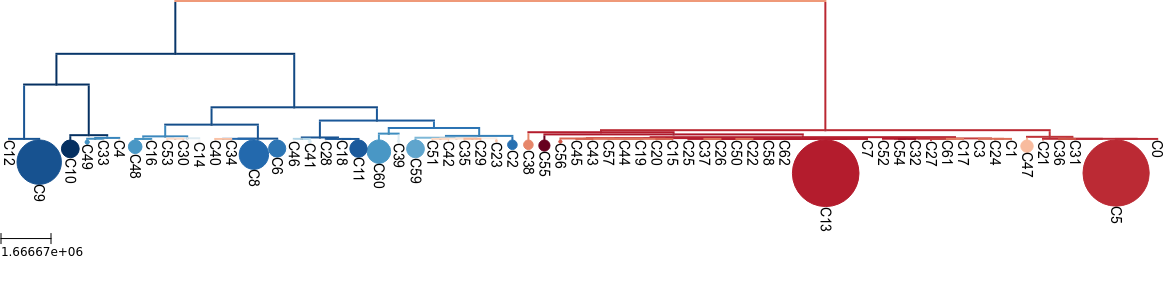

In [28]:
# Beta (INS)
ts = get_TreeStyle_expression(t, my_gene, log_tpm_states, hierarchy_df, clst)
t.render('%%inline', tree_style=ts)

Let's try a few different genes - all are marker genes from the original paper. This allows us to see which branches of the tree correspond to certain cell types.

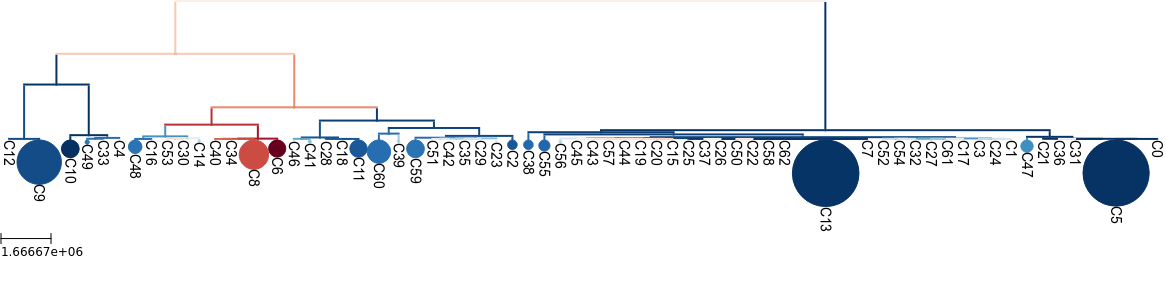

In [29]:
# Alpha (GCG)
ts = get_TreeStyle_expression(t, 'GCG', log_tpm_states, hierarchy_df, clst)
t.render('%%inline', tree_style=ts)

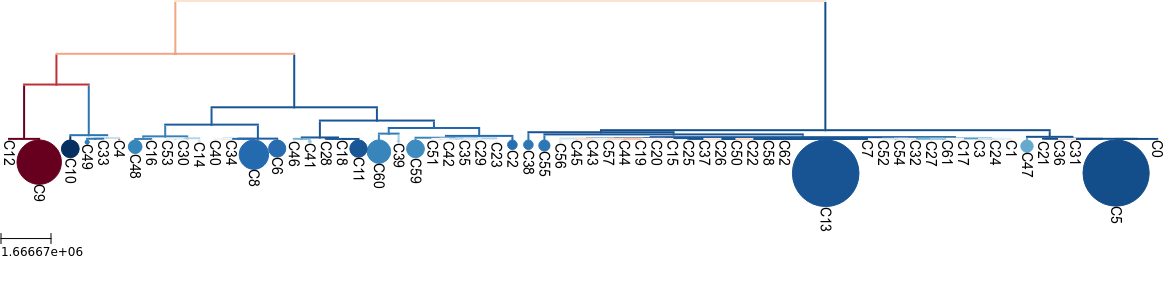

In [30]:
# Delta (SST)
ts = get_TreeStyle_expression(t, 'SST', log_tpm_states, hierarchy_df, clst)
t.render('%%inline', tree_style=ts)

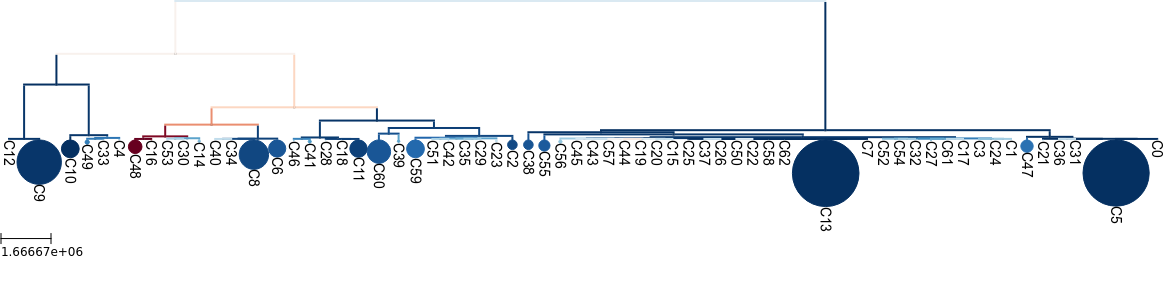

In [31]:
# Gamma (PPY)
ts = get_TreeStyle_expression(t, 'PPY', log_tpm_states, hierarchy_df, clst)
t.render('%%inline', tree_style=ts)

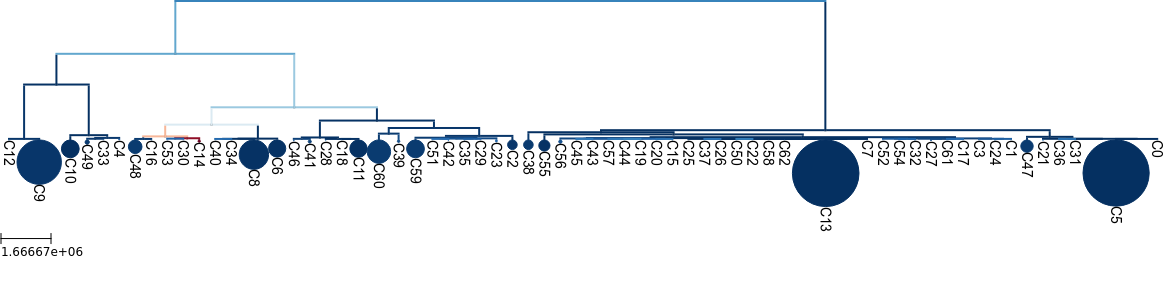

In [32]:
# Epsilon (GHRL)
ts = get_TreeStyle_expression(t, 'GHRL', log_tpm_states, hierarchy_df, clst)
t.render('%%inline', tree_style=ts)

## Looking at subtrees in ete3

leaves are labeled C*n* where *n* is the cellstate ID, internal nodes are labeled I0 (root) ... I*(x-1)* where *x* is the number of splits in the tree. The last line in `hierarchy_df` and `gene_scores` correspond to I0, the second last to I1, etc. 

We can also easily look at parts of the tree - for example to examine the transcriptional diversity in *INS* expressing beta cells. The first split therein divides cluster labels 13 and 5. 

In [33]:
# this finds the subbranch of the tree containing clusters 13 and 5
branch = t.get_common_ancestor(['C13', 'C5']) 
branch.name

'I7'

In [34]:
n_steps = len(hierarchy_df)

split_id = 7  # id of internal node (branch name)
merge_id = n_steps - split_id - 1  # corresponding line in hierarchy_df
merge_id

54

In [35]:
hierarchy_df.tail(10)

,cluster_new,cluster_old,delta_LL
52,39,60,-2.586377e+04
53,1,38,-4.669235e+04
54,0,1,-6.829872e+04
55,2,39,-7.298716e+04
56,6,14,-1.120241e+05
57,2,11,-1.355214e+05
58,2,6,-4.422420e+05
59,4,9,-7.587676e+05
60,2,4,-1.024143e+06
61,0,2,-1.760324e+06


In [36]:
# first check out interesting genes corresponding to this split
gene_scores = score_df.iloc[-split_id-1, 4:]
gene_scores.sort_values()

IAPP      -22.894024
NEUROD1    -9.050794
RBP4       -7.658603
MMP7       -7.030888
DLK1       -6.576803
             ...    
CTRB2       5.159770
PPY         5.774202
REG1A      11.584576
GCG        12.994219
SST        59.471782
Name: 54, Length: 16015, dtype: float64

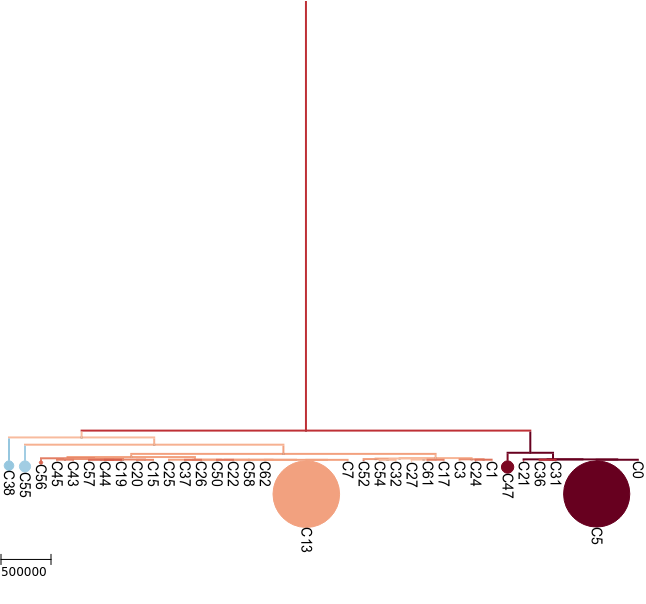

In [37]:
# plotting this subbranch works the same as before
ts = get_TreeStyle_expression(branch, 'IAPP', log_tpm_states, hierarchy_df, clst)
ts.scale=1e-4  # adjust the scale to see more details at the bottom
branch.render('%%inline', tree_style=ts)

I8


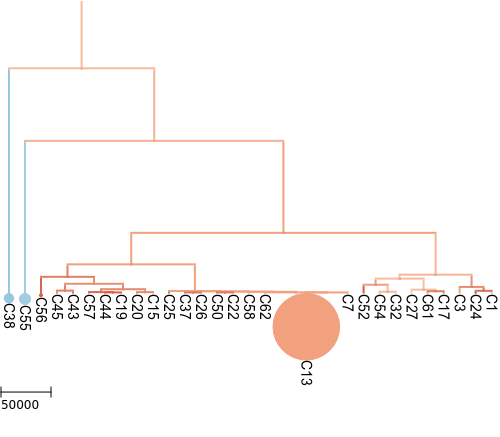

In [38]:
# zoom into the left part of the tree in the same way as previously
branch = t.get_common_ancestor(['C38', 'C1'])
print(branch.name)
ts = get_TreeStyle_expression(branch, 'IAPP', log_tpm_states, hierarchy_df, clst)
ts.scale = 1e-3
branch.render('%%inline', tree_style=ts)